In [180]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np

subreddit = 'ukraine'
stop = nltk.corpus.stopwords.words('english')

read file and add title and selftext to process

todo: preprocess - dates x200b bill gate social medium? 

In [181]:
filename = f'./data/{subreddit}_filtered.csv'
dataframe = pd.read_csv(filename)

In [182]:
dataframe['self_text'] = dataframe['self_text'].apply(str)
selftexts = dataframe[['self_text']]
selftexts = selftexts.drop(selftexts.index[selftexts['self_text'] == 'delete'], axis=0, inplace=False)
selftexts = selftexts.drop(selftexts.index[selftexts['self_text'] == 'remove'], axis=0, inplace=False)
selftexts = selftexts.drop(selftexts.index[selftexts['self_text'] == 'nan'], axis=0, inplace=False)

dataframe['title'] = dataframe['title'].apply(str)
titles = dataframe[['title']]
titles = titles.drop(titles.index[titles['title'] == 'nan'], axis=0, inplace=False)

submissions = list(dataframe.title) + list(selftexts.self_text)

In [191]:
preprocessed_submissions = []

for submission in submissions:
    submission = [word for word in submission.split() if word not in stop]
    #submission = [word for word in submission.split()]
    preprocessed_submissions.append(submission)

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

def createWordCloud(ngram_range, max_features):
    submissions_string = []

    for submission in preprocessed_submissions:
        submissions_string.append(' '.join(submission))

    countvec = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngrams = countvec.fit_transform(submissions_string)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = countvec.vocabulary_
    df_ngram = pd.DataFrame([(k,count_values[i]) for k,i in vocab.items()]).rename(columns={0: 'ngram', 1:'frequency'})
    df_ngram = df_ngram.sort_values(by='frequency', ascending=False)
    
    df_ngram.head(20).plot.barh(x='ngram', y='frequency', title=f'r/{subreddit} Word Frequencies', color='thistle').invert_yaxis()

    df_ngram = dict(zip(df_ngram.ngram, df_ngram.frequency))
    #pronouns(df_ngram)
    
    wc = WordCloud(max_words=100, background_color='white').generate_from_frequencies(df_ngram)
    plt.figure(figsize = (14, 14))
    plt.axis('off')
    plt.title(f'r/{subreddit} wordcloud')
    plt.imshow(wc)

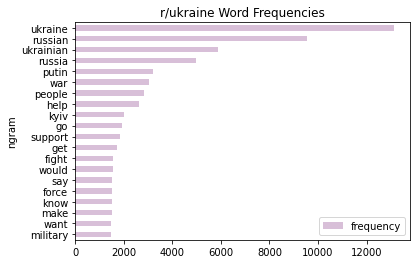

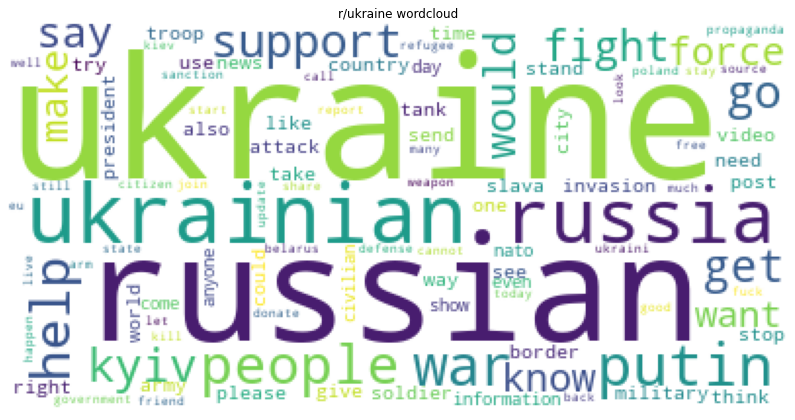

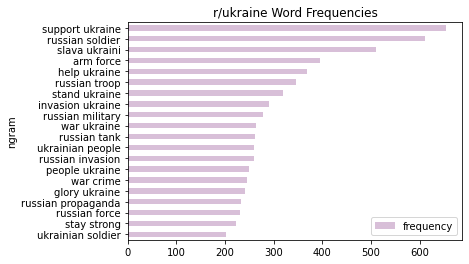

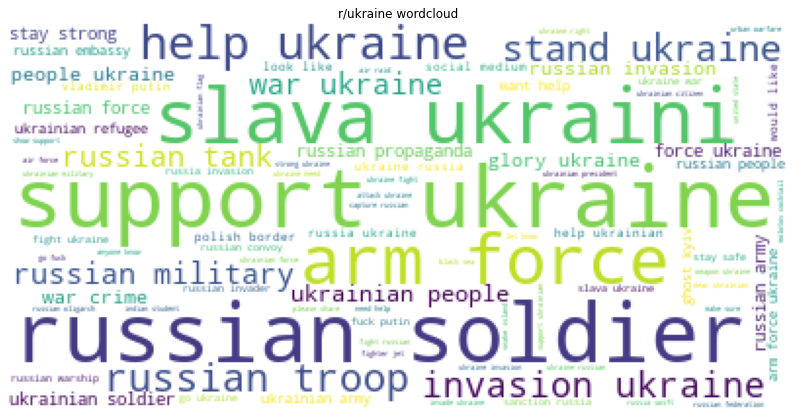

In [196]:
createWordCloud((1,1), None)
createWordCloud((2,3), 10000)

consp {'i': 1128, 'you': 2798, 'he': 1418, 'she': 181, 'they': 3528, 'we': 2052}
ukraine {'i': 2894, 'you': 7739, 'he': 2810, 'she': 549, 'they': 6779, 'we': 4065}

covid always in connection to war! in r/conspiracy

todo: i.e. filter for only nouns
check which pronouns are prevalent

In [197]:
def pronouns(df):
    pronouns_dict = {'i': 0, 'you': 0, 'he': 0, 'she': 0, 'they': 0}
    pronouns_dict['i'] = df['me'] + df['my'] + df['mine'] #add i
    pronouns_dict['you'] = df['you'] + df['yours'] + df['your']
    pronouns_dict['we'] = df['we'] + df['us'] + df['our'] + df['ours']
    pronouns_dict['they'] = df['they'] + df['them'] + df['their'] + df['theirs']
    pronouns_dict['he'] = df['he'] + df['him'] + df['his']
    pronouns_dict['she'] = df['she'] + df['her'] + df['hers']
    print(pronouns_dict)